## Project 2: Numerical Methods for Differential Equations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

## Part 1: 2pBVP
Consider the problem:
\begin{equation}
    \tag{1}
    \begin{cases}
        y''=f(x,y)\\
        y(0)=\alpha\\
        y(L)=\beta
    \end{cases}
\end{equation}
On the intervall $x\in[0,L]$. This can be discretized with for $\Delta x=\frac{L}{N+1}$:
\begin{equation}
    \tag{2}
    \begin{cases}
        f(x_i,y_i)=\frac{y_{i+1}-2y_i+y_{i-1}}{\Delta x^2}\\
        y_0=\alpha\\
        y_{N+1}=\beta
    \end{cases}
\end{equation}
This resolves in a system of $N$ equations which can be summarized by $F(y)=\textbf{0}$ where $F$ is the operator such that:
\begin{equation}
    \tag{3}
    \begin{cases}
        F_1(y)=\frac{y_2-2y_1+\alpha}{\Delta x^2}-f(x_1,y_1)\\
        F_i=\frac{y_{i+1}-2y_i+y_{i-1}}{\Delta x^2}-f(x_i,y_i), \qquad i\in[2,N-1]\\
        F_{N}=\frac{\beta-2y_N+y_{N-1}}{\Delta x^2}-f(x_N,y_N)
    \end{cases}
\end{equation}

In a very fundamental case, $F$ is linear and $f(x,y)$ depends only on $x$. This reduces the problem to solving:
$$
\frac{1}{\Delta x^2}
\left(\begin{array}{c c c c} 
-2 & 1 & 0 & \dots\\
1  & -2 & 1 & \dots\\
0 & 1 & -2 & \dots\\
\dots & \dots & \dots & \dots\\
\dots & 1 & -2 & 1
\dots & 0 & 1 & -2  
\end{array}\right)
\left(\begin{array}{c} 
    y_1 \\ y_2 \\ .\\.\\.\\ y_N
\end{array}\right)
=
\left(\begin{array}{c} 
    -\frac{\alpha}{\Delta x^2} +f(x_1)\\ f(x_2) \\ .\\.\\ f(x_{N-1})\\ -\frac{\beta}{\Delta x^2}+f(x_N)
\end{array}\right)
$$ 

## Task 1.1
Write a 2pBVP solver

In [2]:
def toeplitz_like(dim):
    return diags([1, -2, 1], [-1, 0, 1], shape=(dim, dim))

def twopBVP(fvec, alpha, beta, L, N):

    dx = L/(N+1)
    toeplitz = toeplitz_like(len(fvec))/(dx*dx)

    fvec[0]  = fvec[0] -  alpha/(dx*dx)
    fvec[-1] = fvec[-1] - beta /(dx*dx)

    return spsolve(toeplitz, fvec)

def twopBVP_withSteplength(fvec, alpha, beta, L, N):

    dx = L/(N+1)
    toeplitz = toeplitz_like(len(fvec))/(dx*dx)

    fvec[0]  = fvec[0] -  alpha/(dx*dx)
    fvec[-1] = fvec[-1] - beta /(dx*dx)

    return spsolve(toeplitz, fvec), dx

#### Testing

To test the 2pBVP solver above, it is first applied to the function $y=e^{-x}$ which gives that $f(x)=y(x)$ and the intervall is set to $x\in[0,10]$ For which $\alpha=1, \beta = e^{-10}$ and the length $L$ of the intervall is $10$. The global error of the function is further plotted against steplength $\Delta x = \frac{L}{N+1}$

In [13]:
def f(x):
    return np.exp(-x)

x = np.linspace(0,10,1000)

fvec = np.zeros(1000-2)
for i in range(len(fvec)):
    fvec[i] = f(x[i])

y = twopBVP(fvec, 1, np.e**(-10), 1, 100)
y = np.concatenate(([1],y))
y = np.concatenate((y,[np.e**(-10)]))

exact_sol = np.zeros_like(x)

for i, x_n in enumerate(x):
    exact_sol[i] = np.e**(-x_n)
 

Text(0, 0.5, 'y')

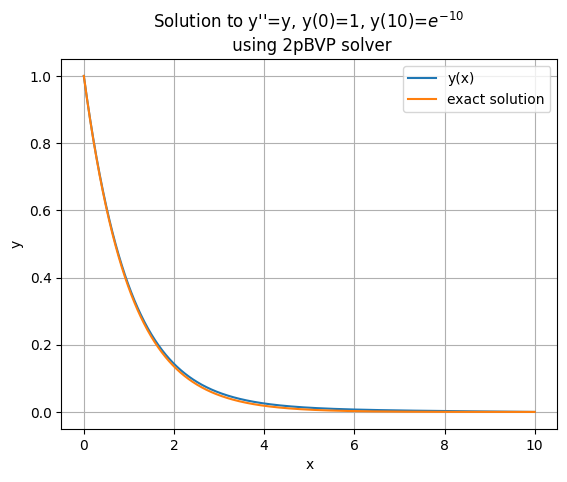

In [14]:
plt.plot(x,y, label='y(x)')
plt.plot(x,exact_sol, label='Exact olution')
plt.title('Solution to y\'\'=y, y(0)=1, y(10)=$e^{-10}$ \n using 2pBVP solver')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

In [5]:
Nvec     = [int(np.power(2,i)) for i in range(3, 10)]
stepgrid = np.zeros_like(Nvec)
error    = np.zeros_like(Nvec)
stepgrid = stepgrid.astype(float)
error    = error.astype(float)

for i, dx in enumerate(Nvec):
    stepgrid[i] = 10/(dx+1)
    approx      = twopBVP(fvec, 0, np.e**(-10), 10, dx)
    error[i]    = abs(approx[-1]-np.e**(-10))

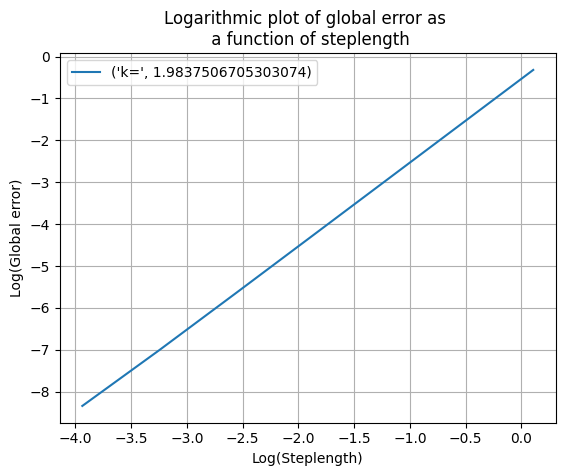

In [8]:
k = np.log(error[-1]/error[0])/np.log(stepgrid[-1]/stepgrid[0])
plt.plot(np.log(stepgrid), np.log(error), label=('k=', k))
plt.title('Logarithmic plot of global error as \n a function of steplength')
plt.xlabel('Log(Steplength)')
plt.ylabel('Log(Global error)')
plt.legend()
plt.grid()

## The Beam Equation

An elastic beam under load is deflected in accordance with its material properties and the applied load. According to elasticity theory, the deflection $u$ is governed by the differential equations:
\begin{equation}
\tag{4}
    \begin{cases}
        M''=q\\
        u''=\frac{M}{EI}
    \end{cases}
\end{equation}
where $q(x)$ is the load density (N/m); $M(x)$ is the bending moment (Nm);
$E$ is Young’s modulus of elasticity (N/m $^2$); $I$ is the beam’s cross-section
moment of inertia (m $^4$); and u is the beam’s centerline deflection (m). The beam is supported which gives that $u(0)=u(L)=0$. Furthermore, it is assumed that no bending is given at endpoints resulting in $M(0)=M(L)=0$

## Task 1.2

Given that $L=10$, $E=1.9\times 10^11$Nm $^{-2}$ and the beam cross-section is given as 
\begin{equation*}
    I(x)=\frac{1}{1000}\left(3-2\cos^{12}\frac{\pi x}{L}\right)
\end{equation*}
The problem is solved for the load $q(x)=-50\ 000$ N/m below.

Firstly, the equation for $M$ is solved using the 2pBVP Solver from above

def 